<a href="https://colab.research.google.com/github/mamenaca/TareasMineriaDatos_Semana1/blob/main/2_Regresion/2_ModeloNolineal_EjSinc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ejemplo mínimos cuadrados para regresión y su extensión no lineal

[sklearn.linear model.LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

Regresor lineal por mínimos cuadrados

\begin{equation}
\omega^* = \arg\min_\omega \|y-Xw\|^2_2
\end{equation}


[sklearn.kernel ridge.KernelRidge](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)

Regresor rígido kernel



\begin{equation}
\omega^* = \arg\min_\omega \|y-\Phi \omega\|^2_2 + \alpha\|\omega\|^2_2
\end{equation}

\begin{equation}
\omega^* = (\Phi^\top \Phi+\alpha I)^{-1}\Phi^\top y
\end{equation}


\begin{equation}
\omega^* = \Phi^\top(\Phi \Phi^\top+\alpha I)^{-1}y = k(\cdot)^\top(K+\alpha I)^{-1}y
\end{equation}

# Ejercicio 1

- Presente la solución al problema de optimización kernel ridge (Ver [Kernel Ridge Regression](https://web2.qatar.cmu.edu/~gdicaro/10315-Fall19/additional/welling-notes-on-kernel-ridge.pdf) y [material de apoyo](https://github.com/amalvarezme/AnaliticaDatos/blob/master/6_TopicosAvanzados/introKernels.pdf) págs 8 y 9).

$$\Phi = B$$

$$R = I$$ $$P=?$$ factorizar para que quede $\alpha$

$A^T$ 

##**Ejemplo** 

- Se pretende generar un modelo de regresión bajo entradas con ruido blanco Gaussiano, con $\mu_\eta=0$, para seguir una función no lineal tipo sinc(x).

- $y = {\rm{sinc}}(x)+\eta$;  
con $\eta\sim p(\eta)=\mathcal{N}(\eta|\mu_\eta,\sigma_\eta^2)=\frac{1}{\sqrt{2\pi\sigma^2_\eta}}\exp\left(\frac{-\|\eta-\mu_\eta\|_2^2}{2\sigma^2_\eta}\right)$

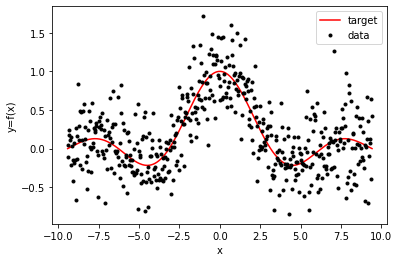

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
N = 500 #número de muestras
X = np.linspace(-3*np.pi,3*np.pi,N) #vector de entrada 
y = np.sinc(X/np.pi) #función sinc -> objetivo
var = 0.1 #varianza del ruido
mue = 0 #media del ruido
noise = mue + np.sqrt(var)*np.random.randn(X.shape[0])#ruido blanco
yn = y + noise #señal co ruido
plt.plot(X,y,'r',label='target' )
plt.plot(X,yn,'k.',label='data')
plt.legend()
plt.xlabel('x')
plt.ylabel('y=f(x)')
plt.show()

**Nota:** $${\rm{sinc}}(\theta)=\frac{\sin(\theta)}{\theta}$$

- Se crean los vectores de entrada y salida tipo aprendizaje de máquina.

In [2]:
ydata = yn.reshape(-1,1)
Xdata = X.reshape(-1,1)
print(Xdata.shape) # N = 500 muestras, P = 1 atributos
print(ydata.shape) # N = 500, regresion univarida

(500, 1)
(500, 1)


- Se entrenará un modelo de aprendizaje con scikitlearn

(350, 1)
(150, 1)


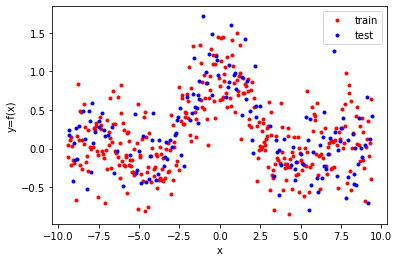

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict

X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata,
                                                    test_size=0.3)#particionar train y test

print(X_train.shape)
print(X_test.shape)

plt.plot(X_train,y_train,'r.',label='train' )
plt.plot(X_test,y_test,'b.',label='test')
plt.legend()
plt.xlabel('x')
plt.ylabel('y=f(x)')
plt.show()

- Se utilizará el modelo [KernelRidge](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html) con función kernel tipo radial basis function (rbf):


$$\kappa(x,x') = \exp\left(\frac{-\gamma\|x-x'\|^2_2}{2}\right)$$

**Nota:** el hiperparámetro $\gamma\in\mathbb{R}^+$ se conoce como precisión y pretende escalar la noción de parecido entre los puntos. La precisión se relaciona comunmente con el parámetro ancho de banda ("varianza") $\sigma\in\mathbb{R}^+$ del modelo rbf, según:

$$\gamma=\frac{1}{\sigma^2}$$

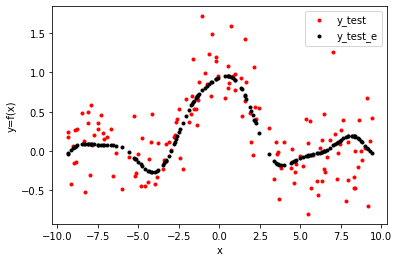

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
gamma = 0.1 #gamma
alpha = 0.001 # valor de regularización
reg = KernelRidge(kernel='rbf',gamma=gamma, alpha = alpha)
reg.fit(X_train,y_train) #ajustar solo sobre train
#prediccion
y_test_e = reg.predict(X_test)
y_train_e = reg.predict(X_train)

plt.plot(X_test,y_test,'r.',label='y_test' )
plt.plot(X_test,y_test_e,'k.',label='y_test_e')
plt.legend()
plt.xlabel('x')
plt.ylabel('y=f(x)')
plt.show()

- Es  necesario encontar unos buenos hiperparámetros para seguir la función no lineal

In [5]:
steps=[('reg', KernelRidge(kernel = 'rbf'))]
parameters = {'reg__alpha' : [0,1e-3,1e-2,0.1,1,10,100,1000],              
              'reg__gamma': [1e-4,1e-3,1e-2,0.1,1,10,100,1000],
              }

pipeline = Pipeline(steps = steps)

grid_search = GridSearchCV(pipeline, parameters, n_jobs=4,cv=10,
                           scoring='neg_mean_absolute_error',verbose=10,refit=True)

grid_search.fit(X_train, y_train)
#mejor modelo entrenado
best_model = grid_search.best_estimator_

print("\nMejores parámetros:\n")
print(grid_search.best_params_)

Fitting 10 folds for each of 64 candidates, totalling 640 fits

Mejores parámetros:

{'reg__alpha': 1, 'reg__gamma': 0.1}


- Se evaluan los datos de test y train con el mejor modelo encontrado

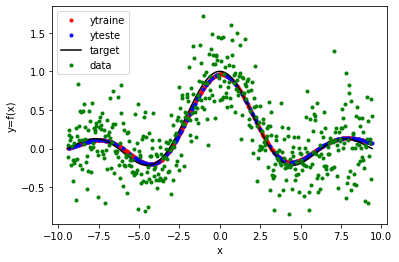

In [6]:
y_test_e = grid_search.best_estimator_.predict(X_test)
y_train_e = grid_search.best_estimator_.predict(X_train)
plt.plot(X_train,y_train_e,'r.',label='ytraine' )
plt.plot(X_test,y_test_e,'b.',label='yteste')
plt.plot(X,y,'k',label='target' )
plt.plot(Xdata,ydata,'g.',label='data' )
plt.legend()
plt.xlabel('x')
plt.ylabel('y=f(x)')
plt.show()

- Visualicemos la función kernel:

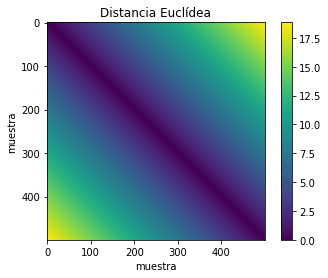

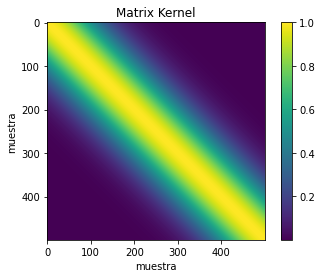

In [7]:
from sklearn.metrics import pairwise_distances as dist

D = dist(X.reshape(-1,1),X.reshape(-1,1)) #disimilitud
K = np.exp(-.5*gamma*D**2)
D.shape
plt.imshow(D)
plt.colorbar()
plt.xlabel('muestra')
plt.ylabel('muestra')
plt.title('Distancia Euclídea')
plt.show()

plt.imshow(K)
plt.colorbar()
plt.xlabel('muestra')
plt.ylabel('muestra')
plt.title('Matrix Kernel')
plt.show()

Recuerde que:

\begin{equation}
\kappa(x,x') = \frac{1}{\sqrt{2\pi \sigma^2}}\exp\left(\frac{-\|x-x'\|_2^2}{2\sigma^2}\right) = \frac{1}{\sqrt{2\pi \sigma^2}}\exp\left(\frac{-\gamma\|x-x'\|_2^2}{2}\right) 
\end{equation}

#Ejercicio 2 

- Visualice el kernel rbf para diferentes condiciones de ruido sintonizando los hiperparámetros del modelo utilizando gridsearch. *Ayuda*: modifique la varianza del ruido.

- Realice una descomposición en valores propios de la matriz kernel para cada una de las condiciones de ruido del punto anterior, qué puede discutir sobre el espectro de la matríz y su influencia en el modelo predictivo de kernel ridge?. Cuál es la relación entre el espectro visualizado y el hiperparámetro de regularización o penalidad encontrado por gridsearch en cada caso?. *Ayuda*: utilizando numpy encuentre la descomposición de valores y vectores propios de $\mathbf{K}$ y $\mathbf{K}+\alpha\mathbf{I}$, según los valores de $\gamma$ y $\alpha$ encontrados por GridsearchCV ante cada condición de ruido evaluada.




In [8]:
varN=[5,2.5,1,0.5,0.25,0.1,0.05]
len(varN)

7

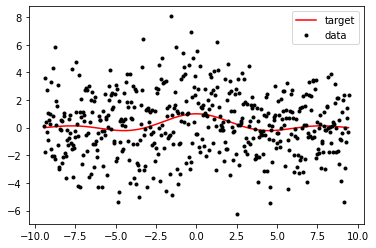

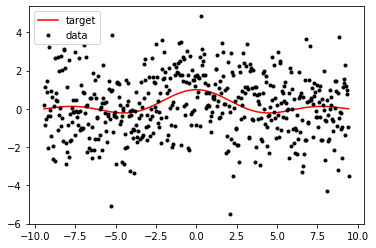

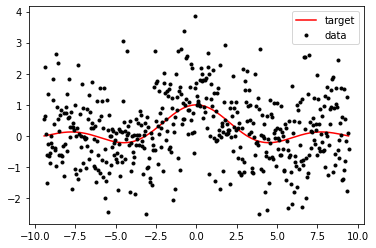

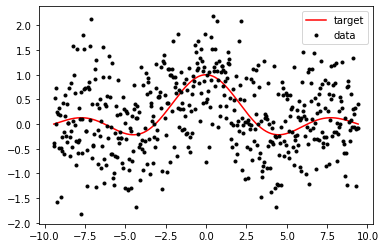

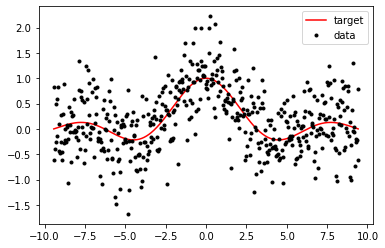

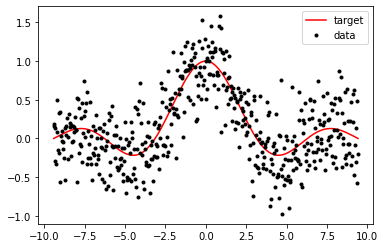

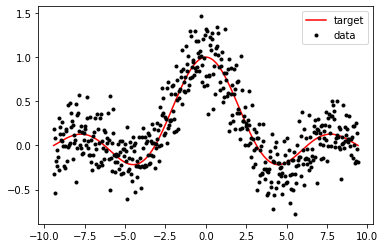

In [9]:
N = 500 #número de muestras
yn = np.zeros((len(varN),N))
X = np.linspace(-3*np.pi,3*np.pi,N) #vector de entrada 
y = np.sinc(X/np.pi) #función sinc -> objetivo
for i in range(len(varN)):
  var = varN[i]  #varianza del ruido
  mue = 0  #media del ruido
  noise = mue + np.sqrt(var)*np.random.randn(X.shape[0])#ruido blanco
  yn[i,:] = y + noise  #señal co ruido
  plt.plot(X,y,'r',label='target' )
  plt.plot(X,yn[i,:],'k.',label='data')
  plt.legend()
  plt.show()

Fitting 10 folds for each of 64 candidates, totalling 640 fits


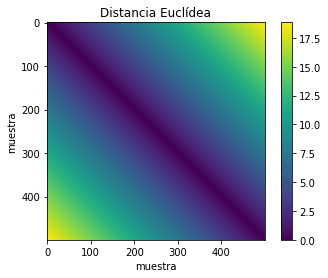

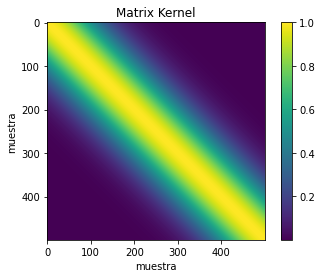

varianza 5

Mejores parámetros:

{'reg__alpha': 100, 'reg__gamma': 0.1}
Fitting 10 folds for each of 64 candidates, totalling 640 fits


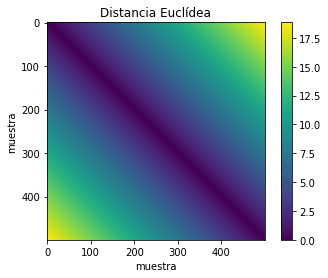

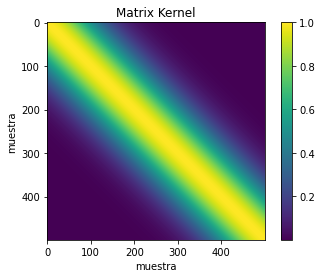

varianza 2.5

Mejores parámetros:

{'reg__alpha': 10, 'reg__gamma': 0.1}
Fitting 10 folds for each of 64 candidates, totalling 640 fits


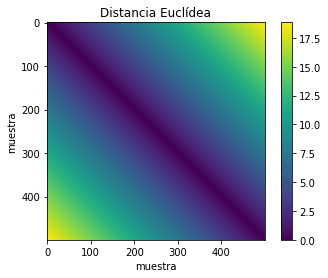

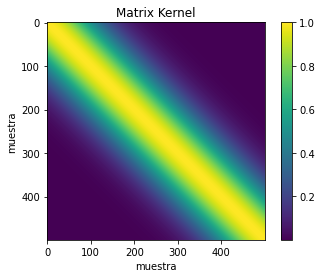

varianza 1

Mejores parámetros:

{'reg__alpha': 10, 'reg__gamma': 0.1}
Fitting 10 folds for each of 64 candidates, totalling 640 fits


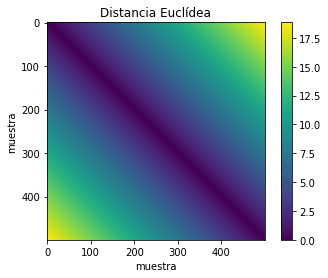

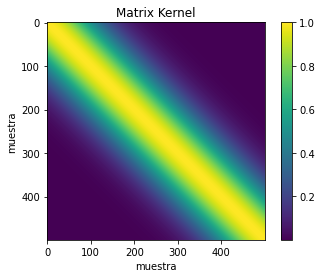

varianza 0.5

Mejores parámetros:

{'reg__alpha': 1, 'reg__gamma': 0.1}
Fitting 10 folds for each of 64 candidates, totalling 640 fits


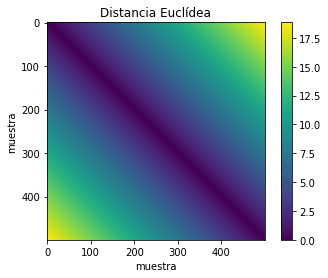

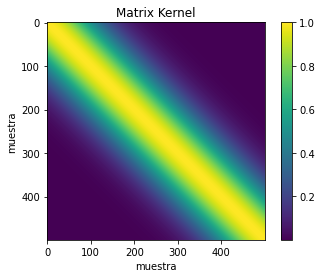

varianza 0.25

Mejores parámetros:

{'reg__alpha': 1, 'reg__gamma': 0.1}
Fitting 10 folds for each of 64 candidates, totalling 640 fits


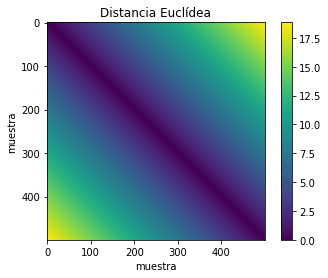

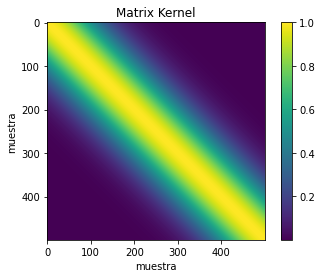

varianza 0.1

Mejores parámetros:

{'reg__alpha': 1, 'reg__gamma': 0.1}
Fitting 10 folds for each of 64 candidates, totalling 640 fits


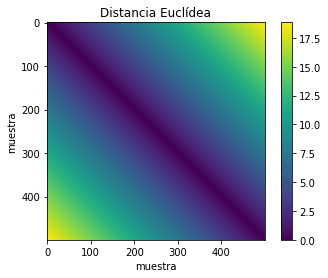

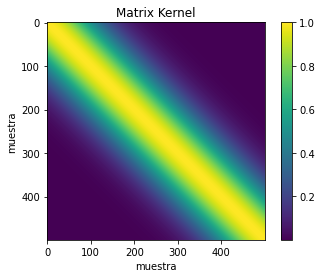

varianza 0.05

Mejores parámetros:

{'reg__alpha': 1, 'reg__gamma': 0.1}


In [13]:
Xdata = X.reshape(-1,1) #N=500, P= 1
y = y.reshape(-1,1)
for i in range(len(varN)):
  ydata = yn[i,:].reshape(-1,1)
  X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata,
                                                    test_size=0.3)#particionar train y test
  steps=[('reg', KernelRidge(kernel = 'rbf'))]
  parameters = {'reg__alpha' : [0,1e-3,1e-2,0.1,1,10,100,1000],              
                'reg__gamma': [1e-4,1e-3,1e-2,0.1,1,10,100,1000],
                }

  pipeline = Pipeline(steps = steps)

  grid_search = GridSearchCV(pipeline, parameters, n_jobs=4,cv=10,
                            scoring='neg_mean_absolute_error',verbose=10,refit=True)  
  grid_search.fit(X_train, y_train)
  ##grafico
  gamma= grid_search.best_params_['reg__gamma']
  alfa=grid_search.best_params_['reg__alpha']
  K = np.exp(-.5*gamma*D**2)
  Kalpha = K + alpha*np.eye(N)
  val,vec = np.linalg.eig(K)
  val_a,vec_a = np.linalg.eig(Kalpha)
  D.shape
  plt.imshow(D)
  plt.colorbar()
  plt.xlabel('muestra')
  plt.ylabel('muestra')
  plt.title('Distancia Euclídea')
  plt.show()
  plt.imshow(K)
  plt.colorbar()
  plt.xlabel('muestra')
  plt.ylabel('muestra')
  plt.title('Matrix Kernel')
  plt.show()
  ##
  #mejor modelo entrenado
  best_model = grid_search.best_estimator_
  print("varianza",varN[i])
  print("\nMejores parámetros:\n")
  print(grid_search.best_params_)

El alpha es un filtro y aumenta con la varianza